In [1]:
import os
from docx import Document
from datetime import datetime
from typing import List, Dict
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from IPython.display import Image,display
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, END, MessagesState, START

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [3]:
llm = ChatGroq(model_name = "deepseek-r1-distill-llama-70b",
temperature = 0)
response = llm.invoke("Hi").content
response

'<think>\n\n</think>\n\nHello! How can I assist you today? 😊'

In [4]:
class TravelPlanner:
    def __init__(self, city: str, start_date: str, end_date: str):
        self.city = city
        self.start_date = start_date
        self.end_date = end_date
        self.trip_days = (datetime.strptime(end_date, "%Y-%m-%d") - datetime.strptime(start_date, "%Y-%m-%d")).days + 1

In [5]:
@tool
def get_attractions_and_activities(city: str) -> str:
    """Get top attractions and activities for a given city."""
    return f"Top attractions and activities in {city} include..."

In [6]:
@tool
def get_weather_forecast(city: str, start_date: str, end_date: str) -> str:
    """Get weather forecast for a given city and date range."""
    return f"Weather in {city} from {start_date} to {end_date} will be..."

In [7]:
@tool
def get_hotels_and_transport(city: str, trip_days: int) -> str:
    """Estimate hotel and transport costs for the trip duration."""
    return f"Estimated hotel and transport cost in {city} for {trip_days} days is..."

In [8]:
@tool
def generate_itinerary(city: str, start_date: str, end_date: str) -> str:
    """Generate an itinerary plan for the travel duration."""
    return f"Day-wise itinerary for {city} from {start_date} to {end_date} is..."

In [9]:
@tool
def summarize_trip(weather: str = "", hotels: str = "", attractions: str = "", itinerary: str = "") -> str:
    """Summarize the trip with all info collected from other tools."""
    return f"""
--- Trip Summary ---
{attractions}
{weather}
{hotels}
{itinerary}
--------------------
""".strip()

In [10]:
search = DuckDuckGoSearchRun()

In [11]:
search.invoke("Latest update on Ios 26")

"Apple announced the latest iPhone software, iOS 26, on Monday, June 9. The first release for developers came later the same day. Just three days later, Apple released a second build of the first ... CUPERTINO, CALIFORNIA Apple today previewed iOS 26, a major update that brings a beautiful new design, intelligent experiences, and improvements to the apps users rely on every day.The new design provides a more expressive and delightful experience across the system while maintaining the instant familiarity of iOS. Apple's iOS 26 update introduces a comprehensive suite of enhancements, combining refined design, innovative features, and improved performance. ... New Functionalities. iOS 26 introduces a ... Apple has announced iOS 26, and the upcoming software update includes a long list of new features and changes for iPhones. The first iOS 26 developer beta is now available, and a public beta will ... Apple Maps in iOS 26 (Image credit: Apple). As well as those aforementioned updates to iM

In [12]:
tools = [get_attractions_and_activities, get_hotels_and_transport, get_weather_forecast, generate_itinerary, summarize_trip, search]

In [13]:
llm_with_tools = llm.bind_tools(tools)

In [14]:
response = llm_with_tools.invoke("Hi")

In [15]:
response.content

'Hello! How can I assist you with your travel plans today?'

In [16]:
response.tool_calls

[]

In [17]:
response = llm_with_tools.invoke("What are attractions in New Delhi")

In [18]:
response.content

''

In [19]:
response.tool_calls

[{'name': 'get_attractions_and_activities',
  'args': {'city': 'New Delhi'},
  'id': 'czwrgbvne',
  'type': 'tool_call'}]

In [20]:
SYSTEM_PROMPT = (
    "You are a helpful travel assistant tasked with planning trips using tools for attractions, weather, hotels, itinerary, search, and trip summary. "
    "Select only the tools needed based on the user's request. Always include trip summary at the end."
)


In [21]:
def function_1(state):
    user_question = state["messages"]
    input_question = [SYSTEM_PROMPT]+user_question
    response = llm_with_tools.invoke(input_question)
    return {
        "messages" :[response] 
    }

In [26]:
# Setup graph
builder = StateGraph(MessagesState)
builder.add_node("llm_decision_step", function_1)
builder.set_entry_point("llm_decision_step")

In [27]:
for tool in tools:
    tool_node = ToolNode([tool])
    node_name = f"tool_{tool.name.replace(' ', '_')}"  # Ensure valid node names
    builder.add_node(node_name, tool_node)
    builder.add_edge("llm_decision_step", node_name)
    builder.add_edge(node_name, "llm_decision_step")   # Tool → LLM (loop)


In [28]:
builder.set_finish_point("llm_decision_step") 

In [ ]:
app = builder.compile()

result = app.invoke(
    {"messages": [HumanMessage("I’m planning a trip to Delhi on 1st–2nd July. Give me a trip summary.")]},
    config={"recursion_limit": 100}
)
final_outputs = [msg.content for msg in result["messages"] if isinstance(msg, AIMessage)]
print(final_outputs[-1])

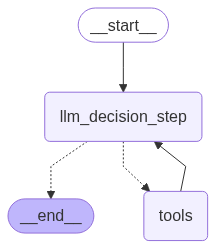

In [65]:
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [29]:
message = [HumanMessage("Hi, I am planning trip to New Delhi for 2 days, 1st and 2nd July, give me attractions and hotel accomodations")]

In [30]:
react_graph.invoke({"messages":message})

{'messages': [HumanMessage(content='Hi, I am planning trip to New Delhi for 2 days, 1st and 2nd July, give me attractions and hotel accomodations', additional_kwargs={}, response_metadata={}, id='be5bdc71-bb83-4a26-b943-90965abf609a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '62jgwphr3', 'function': {'arguments': '{"city":"New Delhi"}', 'name': 'get_attractions_and_activities'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 468, 'prompt_tokens': 513, 'total_tokens': 981, 'completion_time': 1.701818182, 'prompt_time': 0.033310276, 'queue_time': 0.054280113000000005, 'total_time': 1.7351284580000002}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--33051968-9d2d-47d8-9af3-ec865d84922b-0', tool_calls=[{'name': 'get_attractions_and_activities', 'args': {'city': 'New Delhi'}, 'id': '62jgwphr3', 'type': 'tool_call'}], usage_metadata={'inpu

In [31]:
for m in message:
  m.pretty_print()

================================ Human Message =================================

Hi, I am planning trip to New Delhi for 2 days, 1st and 2nd July, give me attractions and hotel accomodations


In [32]:
final_outputs = [msg.content for msg in message if isinstance(msg, AIMessage) and msg.content.strip()]


In [34]:

#final_outputs = [msg.content for msg in result["messages"] if isinstance(msg, AIMessage) and msg.content.strip()]

# Print the last complete assistant message
if final_outputs:
    print(final_outputs[-1])
else:
    print("No final AI response found.")

No final AI response found.


In [38]:
message = [HumanMessage("Help me plan a 2-day trip to New Delhi on 1st and 2nd July. Include weather forecasts, attractions, hotel accomodation, transport, full itinerary, and a short summary.")]

In [39]:
result = react_graph.invoke(
    {"messages": message},
    config={"recursion_limit": 100}
)

In [40]:
final_outputs = [msg.content for msg in result["messages"] if isinstance(msg, AIMessage) and msg.content.strip()]

# Print the last complete assistant message
if final_outputs:
    print(final_outputs[-1])
else:
    print("No final AI response found.")

Here's your detailed trip plan for a 2-day trip to New Delhi on 1st and 2nd July:

---

### **Weather Forecast:**
- **Date:** 1st July to 2nd July
- **Conditions:** [Insert weather forecast details here]

---

### **Top Attractions and Activities:**
1. **Attraction/Activity 1:** [Insert attraction/activity details here]
2. **Attraction/Activity 2:** [Insert attraction/activity details here]
3. **Attraction/Activity 3:** [Insert attraction/activity details here]

---

### **Hotel and Transport Costs:**
- **Estimated Cost:** [Insert cost details here]

---

### **Itinerary:**

#### **Day 1 (1st July):**
- **Morning:** [Insert activity details here]
- **Afternoon:** [Insert activity details here]
- **Evening:** [Insert activity details here]

#### **Day 2 (2nd July):**
- **Morning:** [Insert activity details here]
- **Afternoon:** [Insert activity details here]
- **Evening:** [Insert activity details here]

---

### **Trip Summary:**
- **Weather:** [Insert weather summary here]
- **Attrac

In [41]:
def save_to_docx(text, filename="travel_plan_output_2.docx"):
    doc = Document()
    doc.add_heading("AI Travel Assistant Output", level=1)
    doc.add_paragraph(text)
    doc.save(filename)
    print(f"✅ Output saved to '{filename}'")

In [42]:
save_to_docx(final_outputs[-1])

✅ Output saved to 'travel_plan_output_2.docx'
